In [1]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import cosine_similarity
from mtcnn import MTCNN
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import pickle


In [6]:
# Parámetros
img_res = 128  # Resolución de las imágenes
threshold = 0.99  # Umbral de similitud para reconocimiento
embeddings_file = 'embeddings.pkl'
names_file = 'names.pkl'

In [7]:
# Inicializar el detector de rostros MTCNN
detector = MTCNN()

# Cargar el modelo VGG16 pre-entrenado como extractor de embeddings
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_res, img_res, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
embedding_model = Model(inputs=base_model.input, outputs=x)

# Congelar las capas del modelo
for layer in embedding_model.layers:
    layer.trainable = False

# Normalizador de embeddings
in_encoder = Normalizer(norm='l2')

In [8]:
# Funciones para guardar y cargar embeddings y nombres
def save_data(embeddings, names):
    with open(embeddings_file, 'wb') as f:
        pickle.dump(embeddings, f)
    with open(names_file, 'wb') as f:
        pickle.dump(names, f)

def load_data():
    try:
        with open(embeddings_file, 'rb') as f:
            embeddings = pickle.load(f)
        with open(names_file, 'rb') as f:
            names = pickle.load(f)
        return embeddings, names
    except FileNotFoundError:
        return np.empty((0, embedding_model.output_shape[1])), []

# Función para extraer rostros utilizando MTCNN
def extract_faces(img, img_res=img_res):
    faces = []
    coords_list = []
    results = detector.detect_faces(img)
    for result in results:
        x1, y1, width, height = result['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        face = img[y1:y2, x1:x2]
        face = cv2.resize(face, (img_res, img_res))
        faces.append(face)
        coords_list.append((x1, y1, x2, y2))
    return faces, coords_list

# Función para reconocer un rostro basado en embeddings
def recognize_face(face_embedding, embeddings, names, threshold=threshold):
    if len(embeddings) == 0:
        return 'Desconocido', 0.0
    # Normalizar embeddings
    face_embedding_norm = in_encoder.transform(face_embedding.reshape(1, -1))
    embeddings_norm = in_encoder.transform(embeddings)
    # Calcular similitudes
    similarities = cosine_similarity(face_embedding_norm, embeddings_norm)
    max_similarity = np.max(similarities)
    index = np.argmax(similarities)
    print(f"Similitudes: {similarities}")
    print(f"Máxima similitud: {max_similarity}, Índice: {index}, Nombre: {names[index]}")
    if max_similarity > threshold:
        name = names[index]
    else:
        name = 'Desconocido'
    return name, max_similarity

# Función para dibujar rectángulos y mostrar información en el frame
def draw_rectangle_with_info(frame, coords, name, similarity):
    x1, y1, x2, y2 = coords
    color = (0, 255, 0) if name != 'Desconocido' else (0, 0, 255)
    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
    text = f"{name}: {similarity:.2f}"
    cv2.putText(frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)


In [9]:
# Cargar embeddings y nombres existentes
embeddings, names = load_data()
print(f"Embeddings cargados: {embeddings.shape}")
print(f"Nombres cargados: {names}")

# Iniciar la captura de video
cap = cv2.VideoCapture(0)

print("Presiona 'n' para agregar una nueva persona.")
print("Presiona 'q' para salir.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    faces, coords_list = extract_faces(frame)

    if faces:
        for face, coords in zip(faces, coords_list):
            x1, y1, x2, y2 = coords
            # Preprocesar el rostro
            face_normalized = face.astype('float32') / 255.0
            face_expanded = np.expand_dims(face_normalized, axis=0)
            # Extraer embedding
            face_embedding = embedding_model.predict(face_expanded)[0]
            # Reconocer el rostro
            name, similarity = recognize_face(face_embedding, embeddings, names)
            # Dibujar rectángulo y mostrar información
            draw_rectangle_with_info(frame, coords, name, similarity)
    else:
        cv2.putText(frame, "No se detectó rostro", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Mostrar el cuadro de video
    cv2.imshow("Reconocimiento Facial en Tiempo Real", frame)

    key = cv2.waitKey(1) & 0xFF

    # Presiona 'n' para agregar una nueva persona
    if key == ord('n'):
        print("Iniciando captura de nueva persona...")
        name = input("Introduce el nombre de la persona: ")
        num_images = int(input("¿Cuántas imágenes quieres capturar? (recomendado al menos 5): "))
        captured_images = 0

        # Cargar embeddings y nombres existentes
        embeddings, names = load_data()
        print(f"Embeddings antes de agregar: {embeddings.shape}")
        print(f"Nombres antes de agregar: {names}")

        while captured_images < num_images:
            ret, frame = cap.read()
            faces, coords_list = extract_faces(frame)
            if faces:
                face = faces[0]  # Tomar el primer rostro detectado
                coords = coords_list[0]
                x1, y1, x2, y2 = coords

                # Preprocesar el rostro
                face_normalized = face.astype('float32') / 255.0
                face_expanded = np.expand_dims(face_normalized, axis=0)

                # Extraer embedding
                face_embedding = embedding_model.predict(face_expanded)[0]

                # Agregar embedding y nombre a las listas
                embeddings = np.vstack([embeddings, face_embedding])
                names.append(name)

                # Dibujar rectángulo y mostrar información
                cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 0), 2)
                cv2.putText(frame, f"Capturado: {captured_images + 1}/{num_images}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

                captured_images += 1
            else:
                cv2.putText(frame, "No se detectó rostro", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

            # Mostrar el cuadro de video
            cv2.imshow("Capturando Nueva Persona", frame)
            cv2.waitKey(1)

        # Guardar los embeddings y nombres actualizados
        save_data(embeddings, names)
        print(f"Persona '{name}' agregada con éxito.")
        print(f"Embeddings después de agregar: {embeddings.shape}")
        print(f"Nombres después de agregar: {names}")

    # Presiona 'q' para salir
    elif key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Embeddings cargados: (15, 512)
Nombres cargados: ['piero', 'piero', 'piero', 'piero', 'piero', 'piero', 'piero', 'piero', 'piero', 'piero', 'piero', 'piero', 'piero', 'piero', 'piero']
Presiona 'n' para agregar una nueva persona.
Presiona 'q' para salir.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Similitudes: [[0.99486802 0.99416413 0.99413201 0.99346658 0.99474367 0.99474027
  0.99377717 0.9941273  0.99357072 0.99320052 0.99282577 0.99307106
  0.9903131  0.98780985 0.98732678]]
Máxima similitud: 0.994868020601013, Índice: 0, Nombre: piero
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Similitudes: [[0.99626544 0.9964657  0.99585719 0.99544503 0.99628566 0.99622757
  0.99559507 0.99608674 0.99531244 0.99525591 0.99528744 0.99499925
  0.99180092 0.99008133 0.98965323]]
Máxima similitud: 0.9964657006603989, Índice: 1, Nombre: piero
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Similitudes: [[0.99782642 0.99741717 0.99726456 0.99751628 0.99778806 0.99785488
  0.99734471 0.99778694 0.99710177 0.99670211 0.9971

: 

In [2]:
# Ruta de las imágenes
data_dir = './imagenes'

# Preparar los datos
labels = []
images = []

# Etiquetas basadas en los nombres de las carpetas
label_dict = {'cuy': 0, 
               'piero': 1, 
               'samuel': 2,
            #     'christian': 3
                }

img_res=128

In [ ]:
import json

# Guardar label_dict en un archivo JSON
def save_label_dict(label_dict, filename='labels.json'):
    with open(filename, 'w') as f:
        json.dump(label_dict, f)

# Cargar label_dict desde un archivo JSON
def load_label_dict(filename='labels.json'):
    with open(filename, 'r') as f:
        return json.load(f)

# Al agregar una nueva persona
if name not in label_dict.values():
    new_label = max(label_dict.values()) + 1
    label_dict[name] = new_label
    label_dict_inverted[new_label] = name
    # Guardar el label_dict actualizado
    save_label_dict(label_dict)

In [ ]:
# Cargar label_dict
try:
    label_dict = load_label_dict()
    label_dict_inverted = {int(v): k for k, v in label_dict.items()}
except FileNotFoundError:
    # Si no existe, inicializar
    label_dict = {'cuy': 0, 'piero': 1, 'samuel': 2}
    label_dict_inverted = {v: k for k, v in label_dict.items()}

In [3]:
# Carga el modelo VGG16 pre-entrenado sin las capas superiores
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_res, img_res, 3))

# Agrega una capa Global Average Pooling para obtener el embedding
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
embedding_model = Model(inputs=base_model.input, outputs=x)

# Congela las capas del modelo base
for layer in embedding_model.layers:
    layer.trainable = False

# El modelo 'embedding_model' ahora genera un vector de características (embedding) para cada rostro

In [4]:
image_data = [(folder, os.path.join(data_dir, folder, image)) for folder in os.listdir(data_dir) for image in os.listdir(os.path.join(data_dir, folder))]

In [5]:
# Preparar los datos
labels = []
embeddings = []

for folder, img_path in image_data:
    img = cv2.imread(img_path)
    face_roi, _ = getImgFromPRE(img, img_res)
    
    if face_roi is not None:
        # Normalizar la imagen
        face_roi = face_roi / 255.0
        face_roi = np.expand_dims(face_roi, axis=0)
        
        # Extraer el embedding
        embedding = embedding_model.predict(face_roi)[0]
        embeddings.append(embedding)
        labels.append(label_dict[folder])

# Convertir a arrays de numpy
embeddings = np.array(embeddings)
labels = np.array(labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━

In [6]:
import pickle

# Guardar embeddings y etiquetas en un archivo
def save_embeddings(embeddings, labels, filename='embeddings.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump({'embeddings': embeddings, 'labels': labels}, f)

# Cargar embeddings y etiquetas desde un archivo
def load_embeddings(filename='embeddings.pkl'):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data['embeddings'], data['labels']

# Guardar los embeddings y etiquetas obtenidos
save_embeddings(embeddings, labels)

In [9]:
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import cosine_similarity

# Cargar embeddings y etiquetas almacenados
embeddings, labels = load_embeddings()
area_threshold = 40000
# Normalizar embeddings
in_encoder = Normalizer(norm='l2')
embeddings = in_encoder.transform(embeddings)

# Invertir el diccionario de etiquetas
label_dict_inverted = {v: k for k, v in label_dict.items()}

# Función para reconocer un rostro basado en embeddings
def recognize_face(face_embedding, embeddings, labels, threshold=0.5):
    # Normalizar el embedding del rostro
    face_embedding = in_encoder.transform(face_embedding.reshape(1, -1))
    # Calcular similitudes
    similarities = cosine_similarity(face_embedding, embeddings)
    # Encontrar la mayor similitud
    max_similarity = np.max(similarities)
    index = np.argmax(similarities)
    if max_similarity > threshold:
        label = labels[index]
        name = label_dict_inverted[label]
    else:
        name = 'Desconocido'
    return name, max_similarity

# Captura de video
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    face_roi, coords = getImgFromPRE(frame, img_res)
    
    if face_roi is not None and coords is not None:
        x1, y1, x2, y2 = coords

        # Normalizar y expandir dimensiones para la predicción
        face_roi_resized = face_roi / 255.0
        face_roi_resized = np.expand_dims(face_roi_resized, axis=0)

        # Extraer el embedding
        face_embedding = embedding_model.predict(face_roi_resized)[0]

        # Reconocer el rostro
        name, similarity = recognize_face(face_embedding, embeddings, labels)

        # Mostrar la predicción en la imagen
        text = f"{name}: {similarity:.2f}"
        cv2.putText(frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Dibujar el rectángulo
        dibujar_rectangulo_con_color(frame, coords, area_threshold)

    # Mostrar el cuadro de video con la predicción
    cv2.imshow("Reconocimiento Facial en Tiempo Real", frame)

    # Presiona 'n' para agregar una nueva persona
    if cv2.waitKey(1) & 0xFF == ord('n'):
        # Capturar y almacenar un nuevo rostro
        if face_roi is not None:
            # Solicitar el nombre de la persona
            name = input("Introduce el nombre de la persona: ")
            # Verificar si la etiqueta ya existe
            if name not in label_dict.values():
                new_label = max(label_dict.values()) + 1
                label_dict[name] = new_label
                label_dict_inverted[new_label] = name
            else:
                new_label = label_dict[name]

            # Extraer el embedding del rostro
            face_embedding = embedding_model.predict(face_roi_resized)[0]
            # Agregar el embedding y la etiqueta a las listas
            embeddings = np.vstack([embeddings, face_embedding])
            labels = np.append(labels, new_label)
            # Guardar los embeddings y etiquetas actualizados
            save_embeddings(embeddings, labels)
            print(f"Persona '{name}' agregada con éxito.")
        else:
            print("No se detectó ningún rostro. Intenta nuevamente.")

    # Presiona 'q' para salir
    elif cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [3]:
image_data = [(folder, os.path.join(data_dir, folder, image)) for folder in os.listdir(data_dir) for image in os.listdir(os.path.join(data_dir, folder))]

for folder, img_path in image_data:
    img = cv2.imread(img_path)

    # face_roi, label = getImgFromCascade(img, label_dict, folder)

    # face_roi, label = getImgFromMTCNN(img, label_dict, folder)

    face_roi, cords = getImgFromPRE(img, img_res)

    if face_roi is not None:
        images.append(face_roi)
        labels.append(label_dict[folder])


In [ ]:
image_data = [(folder, os.path.join(data_dir, folder, image)) for folder in os.listdir(data_dir) for image in os.listdir(os.path.join(data_dir, folder))]


In [8]:
from collections import Counter

# Convertir etiquetas one-hot a etiquetas simples
simple_labels = np.argmax(labels, axis=1)

# Contar las imágenes por clase
label_counts = Counter(simple_labels)
print("Imágenes por clase:", label_counts)


Imágenes por clase: Counter({2: 138, 0: 118, 1: 105})


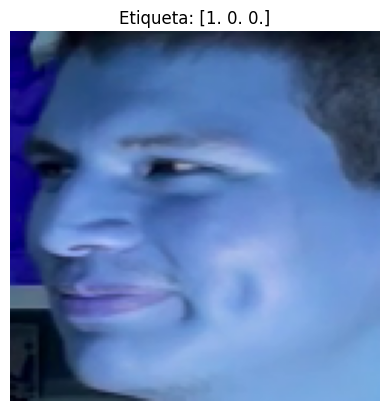

In [29]:
import matplotlib.pyplot as plt

def mostrar_imagen_con_etiqueta(index):
    if index < len(images):
        plt.imshow(images[index])
        plt.title(f"Etiqueta: {labels[index]}")
        plt.axis('off')  # Ocultar los ejes
        plt.show()
    else:
        print("Índice fuera de rango")

# Ejemplo de uso
mostrar_imagen_con_etiqueta(3) # Cambia el índice para ver diferentes imágenes

# Data split

In [11]:
# Convertir a arrays de numpy
images = np.array(images) / 255.0  # Normalizar
labels = np.array(labels)

# Codificación one-hot de las etiquetas
labels = to_categorical(labels)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [12]:
# Crear un generador de aumento de datos
datagen = ImageDataGenerator(
    rotation_range=20,  # Rotación aleatoria hasta 20 grados
    width_shift_range=0.2,  # Desplazamiento horizontal
    height_shift_range=0.2,  # Desplazamiento vertical
    shear_range=0.15,  # Corte
    zoom_range=0.15,  # Zoom
    horizontal_flip=True,  # Volteo horizontal
    fill_mode='nearest'  # Relleno de los píxeles que faltan
)

# Ajustar el generador a las imágenes de entrenamiento
datagen.fit(X_train)

# ENTRENAMIENTO DEL MODELO

In [31]:
# Carga el modelo pre-entrenado sin las capas superiores
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_res,img_res, 3))

# Congela las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Agrega capas superiores personalizadas
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(len(label_dict), activation='softmax')(x)

# Define el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compila el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Entrenar el modelo
history = model.fit( datagen.flow(X_train, y_train, batch_size=32),epochs=100, 
                     validation_data=(X_test, y_test),
                    #  callbacks=[checkpoint]
                     )

Epoch 1/100


c:\Program Files\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 894ms/step - accuracy: 0.3553 - loss: 2.7955 - val_accuracy: 0.5616 - val_loss: 1.2247
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 879ms/step - accuracy: 0.5470 - loss: 1.1142 - val_accuracy: 0.7534 - val_loss: 0.5535
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 881ms/step - accuracy: 0.8303 - loss: 0.5115 - val_accuracy: 0.9726 - val_loss: 0.2692
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 863ms/step - accuracy: 0.9019 - loss: 0.3449 - val_accuracy: 1.0000 - val_loss: 0.1656
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 864ms/step - accuracy: 0.9132 - loss: 0.2884 - val_accuracy: 0.9863 - val_loss: 0.1092
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 884ms/step - accuracy: 0.9506 - loss: 0.1899 - val_accuracy: 1.0000 - val_loss: 0.0713
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 873ms/step - accuracy: 0.9145 - loss: 0.2116 - val_accuracy: 0.9863 - val_loss: 0.0850
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 871ms/step - accuracy: 0.9613 - loss: 0.1458 - val_accuracy: 1.0000 - val_loss: 0.0

In [13]:
# Configurar el checkpoint para guardar el mejor modelo
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1)


# Crear el modelo
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_res, img_res, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_dict), activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
# model.summary()

# Entrenar el modelo
history = model.fit( datagen.flow(X_train, y_train, batch_size=32),epochs=100, 
                     validation_data=(X_test, y_test),
                     callbacks=[checkpoint]
                     )

c:\Program Files\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Program Files\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.2497 - loss: 1.3544
Epoch 1: val_accuracy improved from -inf to 0.35616, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.2563 - loss: 1.3427 - val_accuracy: 0.3562 - val_loss: 1.0627
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3718 - loss: 1.1097
Epoch 2: val_accuracy improved from 0.35616 to 0.42466, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.3707 - loss: 1.1082 - val_accuracy: 0.4247 - val_loss: 0.9904
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4357 - loss: 1.0431
Epoch 3: val_accuracy improved from 0.42466 to 0.46575, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.4411 - loss: 1.0401 - val_accuracy: 0.4658 - val_loss: 0.8519
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5229 - loss: 0.8902
Epoch 4: val_accuracy improved from 0.46575 to 0.73973, saving 

In [15]:
# Diccionario de etiquetas
label_dict_inverted = {0: 'cuy', 1: 'piero', 2: 'samuel'}

# Predicciones en el conjunto de validación
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Generar matriz de confusión y reporte de clasificación
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=label_dict_inverted.values()))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 
[[29  0  0]
 [ 0 18  0]
 [ 0  2 24]]
              precision    recall  f1-score   support

         cuy       1.00      1.00      1.00        29
       piero       0.90      1.00      0.95        18
      samuel       1.00      0.92      0.96        26

    accuracy                           0.97        73
   macro avg       0.97      0.97      0.97        73
weighted avg       0.98      0.97      0.97        73



# TESTING

In [7]:
def dibujar_rectangulo_con_color(frame, coords, area_threshold, tolerance=50):
    """
    Dibuja un rectángulo en el frame con un color que cambia según si está centrado
    y tiene un área mayor al umbral especificado. También muestra el área y el estado de centrado.

    :param frame: El fotograma en el que se va a dibujar el rectángulo.
    :param coords: Coordenadas del rectángulo en formato (x1, y1, x2, y2).
    :param area_threshold: Umbral de área para cambiar el color del rectángulo.
    :param tolerance: Tolerancia en píxeles para considerar el rectángulo como centrado.
    """
    x1, y1, x2, y2 = coords
    area = (x2 - x1) * (y2 - y1)  # Calcular el área del rectángulo

    # Calcular el centro del fotograma y del rectángulo
    frame_center_x = frame.shape[1] // 2
    frame_center_y = frame.shape[0] // 2
    rect_center_x = (x1 + x2) // 2
    rect_center_y = (y1 + y2) // 2

    # Verificar si el rectángulo está centrado dentro de la tolerancia
    is_centered = (abs(rect_center_x - frame_center_x) <= tolerance and 
                   abs(rect_center_y - frame_center_y) <= tolerance)

    # Determinar el color: verde si está centrado y su área es mayor al umbral; rojo en caso contrario
    if is_centered and area > area_threshold:
        color = (0, 255, 0)  # Verde
        centered_text = "Centrado y Rostro cerca"
    else:
        color = (0, 0, 255)  # Rojo
        centered_text = "No Centrado o Rostro alejado"

    # Dibujar el rectángulo en el frame
    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

    # Mostrar el área debajo del rectángulo
    area_text = f"area: {area}"
    cv2.putText(frame, area_text, (x1, y2 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Mostrar si está centrado y mayor al umbral
    cv2.putText(frame, centered_text, (x1, y2 + 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)




In [40]:
cap = cv2.VideoCapture(0)  # 0 es la cámara por defecto

area_threshold = 40000 

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Obtener el rostro detectado y sus coordenadas
    face_roi, coords = getImgFromPRE(frame, img_res)
    
    if face_roi is not None and coords is not None:
        x1, y1, x2, y2 = coords

        # Normalizar y expandir dimensiones para la predicción
        face_roi_resized = face_roi / 255.0
        face_roi_resized = np.expand_dims(face_roi_resized, axis=0)

        # Realizar la predicción
        predictions = model.predict(face_roi_resized)
        class_index = np.argmax(predictions)
        
        # Verificar si class_index está en el diccionario de etiquetas
        if class_index in label_dict_inverted:
            class_label = label_dict_inverted[class_index]
            confidence = predictions[0][class_index]

            # Mostrar la predicción en la imagen
            text = f"{class_label}: {confidence:.2f}"
            cv2.putText(frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Dibujar un cuadro alrededor del rostro detectado
            # cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            dibujar_rectangulo_con_color(frame, coords, area_threshold)

    # Mostrar el cuadro de video con la predicción
    cv2.imshow("Reconocimiento Facial en Tiempo Real", frame)

    # Presiona 'q' para salir
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar la cámara y cerrar las ventanas
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

In [7]:
# Invertir el diccionario para que los índices sean las claves
label_dict_inverted = {v: k for k, v in label_dict.items()}

# Código de la cámara
cap = cv2.VideoCapture(0)  # 0 para la cámara por defecto

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocesar el cuadro para el modelo
    img = cv2.resize(frame, (64, 64))  # Redimensionar a 64x64
    img = img / 255.0  # Normalizar
    img = np.expand_dims(img, axis=0)  # Expansión de dimensiones

    # Hacer una predicción
    predictions = model.predict(img)
    class_index = np.argmax(predictions)
    
    # Verificar si class_index está en label_dict_inverted
    if class_index in label_dict_inverted:
        class_label = label_dict_inverted[class_index]
        confidence = predictions[0][class_index]

        # Mostrar la predicción en la imagen
        text = f"{class_label}: {confidence:.2f}"
        cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Dibujar un cuadrado alrededor del objeto reconocido
        height, width, _ = frame.shape
        top_left = (int(width * 0.3), int(height * 0.3))  # Coordenada superior izquierda del cuadrado
        bottom_right = (int(width * 0.7), int(height * 0.7))  # Coordenada inferior derecha del cuadrado
        cv2.rectangle(frame, top_left, bottom_right, (0, 255, 0), 2)  # Dibujar el rectángulo

    # Mostrar el cuadro
    cv2.imshow("Reconocimiento en tiempo real", frame)

    # Presiona 'q' para salir
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━